#Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Challenge 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2023-2024] AN2DL/Challenge 1


#Import libraries

In [2]:
# Fix randomness
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
# hide warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)
import logging
import random
random.seed(seed)
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
#print(tf.__version__) #check version compatibility
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Our function

In [3]:
def augmentation(x,y):
# it balances the number of sample in (x,y) by upsampling the less frequent class ('unhealthy')
# inputs:
# x -> (N,96,96,3)
# y -> (N,1)
# outputs:
# x_aug -> (M,96,96,3)
# y_aug -> (M,2)

  encoder = OneHotEncoder(handle_unknown='ignore')
  encoder.fit(y)
  dummy = encoder.transform(y).toarray()
  Y = pd.DataFrame(dummy,columns=encoder.categories_)
  Y = Y.to_numpy()
  miss =int(np.sum(Y[:,0])-np.sum(Y[:,1])) #augmentation in order to have the same number healthy and unhelathy subject

  indices = np.where((Y[:, 0] == 0) & (Y[:, 1] == 1))[0] #total number of unhelathy targets (look at the initial unbalance between healthy and unhealthy)
  selected_indices = np.random.choice(indices, miss, replace=False) # Randomly select N indices from the filtered indices
  subset_X = x[selected_indices] # Randomly select N indices from the filtered indices
  #print("Shape of subset_X:", subset_X.shape) # Verify the shape of the subset

  augmentationNet = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal_and_vertical"),
  tfkl.RandomTranslation(0.1,0.1),
  tfkl.RandomRotation(0.25),
  tfkl.RandomZoom(0.2)
  #tfkl.RandomBrightness(0.2, value_range=(0,1)),
  ], name='augmentationNet')

  augmented_X = augmentationNet(subset_X)

  x_aug =np.concatenate((x,augmented_X),axis=0)
  #print(x_aug.shape) #check dimension
  augmented_y = np.ones((miss, 2))
  augmented_y[:, 0] = 0
  augmented_y=augmented_y.astype('int')
  y_aug=np.concatenate((Y,augmented_y),axis=0)
  #print(y.shape) #check dimension
  x_aug, y_aug= shuffle(x_aug, y_aug, random_state=0) # shuffle them to not induce bias

  return x_aug, y_aug

In [4]:
def show_metrics(model,X_val,y_val,preprocess_input):
# it plots the confusion matrix of model and returns accuracy,precision, recall and f1_score
# inputs:
# model
# X_val -> (N,96,96,3)
# y_val -> (N,2)
# preprocess_input -> preprocess used in the input of the respective model

  predictions = model.predict(preprocess_input(X_val*255), verbose=0)
  predictions.shape
  cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
  accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
  precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()
  print('\n\n')
  return accuracy,precision,recall,f1

In [5]:
def plot_loss_accuracy_trend(history,metrics='val_accuracy'):
  # it plots the graph of the trend of training and validation accuracy and loss
  # input:
  # history -> ()
  # metrics -> string that identifies the criteria of early stopping and selection of the best weights

  if metrics=='val_accuracy':
    best_epoch = np.argmax(history['val_accuracy']) # epoch with the highest validation accuracy
  else:
    best_epoch = np.argmin(history['val_loss']) # epoch with the lowest validation loss

  plt.figure(figsize=(20, 5))
  plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=0.3)
  plt.figure(figsize=(20, 5))
  plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=0.3)
  plt.show()

#Data

##Import data

In [6]:
import zipfile
zip = zipfile.ZipFile('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge 1/public_data.zip')
zip.extractall('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge 1')
zip.close()

In [7]:
input_directory =('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge 1/public_data')
data=b = np.load('public_data.npz', allow_pickle=True)

In [8]:
print(data.files)

['data', 'labels']


In [9]:
y=data['labels']
x=data['data']

##Inspect data

In [10]:
print('x shape: ',x.shape)
print('y shape: ',y.shape)

x shape:  (5200, 96, 96, 3)
y shape:  (5200,)


In [11]:
x[1] # to visualize the type of data

array([[[ 94., 125.,  83.],
        [ 46.,  79.,  34.],
        [ 62., 103.,  47.],
        ...,
        [129., 178., 133.],
        [125., 174., 127.],
        [124., 173., 126.]],

       [[ 67.,  98.,  56.],
        [ 31.,  64.,  19.],
        [ 57.,  98.,  42.],
        ...,
        [129., 177., 135.],
        [129., 178., 133.],
        [130., 179., 134.]],

       [[  1.,  32.,   0.],
        [  0.,  30.,   0.],
        [ 53.,  94.,  38.],
        ...,
        [139., 185., 149.],
        [135., 181., 144.],
        [134., 180., 143.]],

       ...,

       [[144., 194., 159.],
        [139., 189., 154.],
        [139., 189., 154.],
        ...,
        [138., 193., 151.],
        [138., 193., 153.],
        [142., 197., 157.]],

       [[142., 192., 157.],
        [142., 192., 157.],
        [146., 196., 161.],
        ...,
        [147., 201., 165.],
        [145., 199., 163.],
        [152., 206., 170.]],

       [[141., 191., 156.],
        [143., 193., 158.],
        [148., 1

In [12]:
# to visualize classes and data distribution
unique, count = np.unique(y, return_counts=True)
print('Target labels:',unique)
for i,u in enumerate(unique):
    print(f'Quality {unique[i]} has {count[i]} samples')

Target labels: ['healthy' 'unhealthy']
Quality healthy has 3199 samples
Quality unhealthy has 2001 samples


In [13]:
x=x/255 # convert into 0-1
y=np.expand_dims(y,axis=-1) #expand the dimension

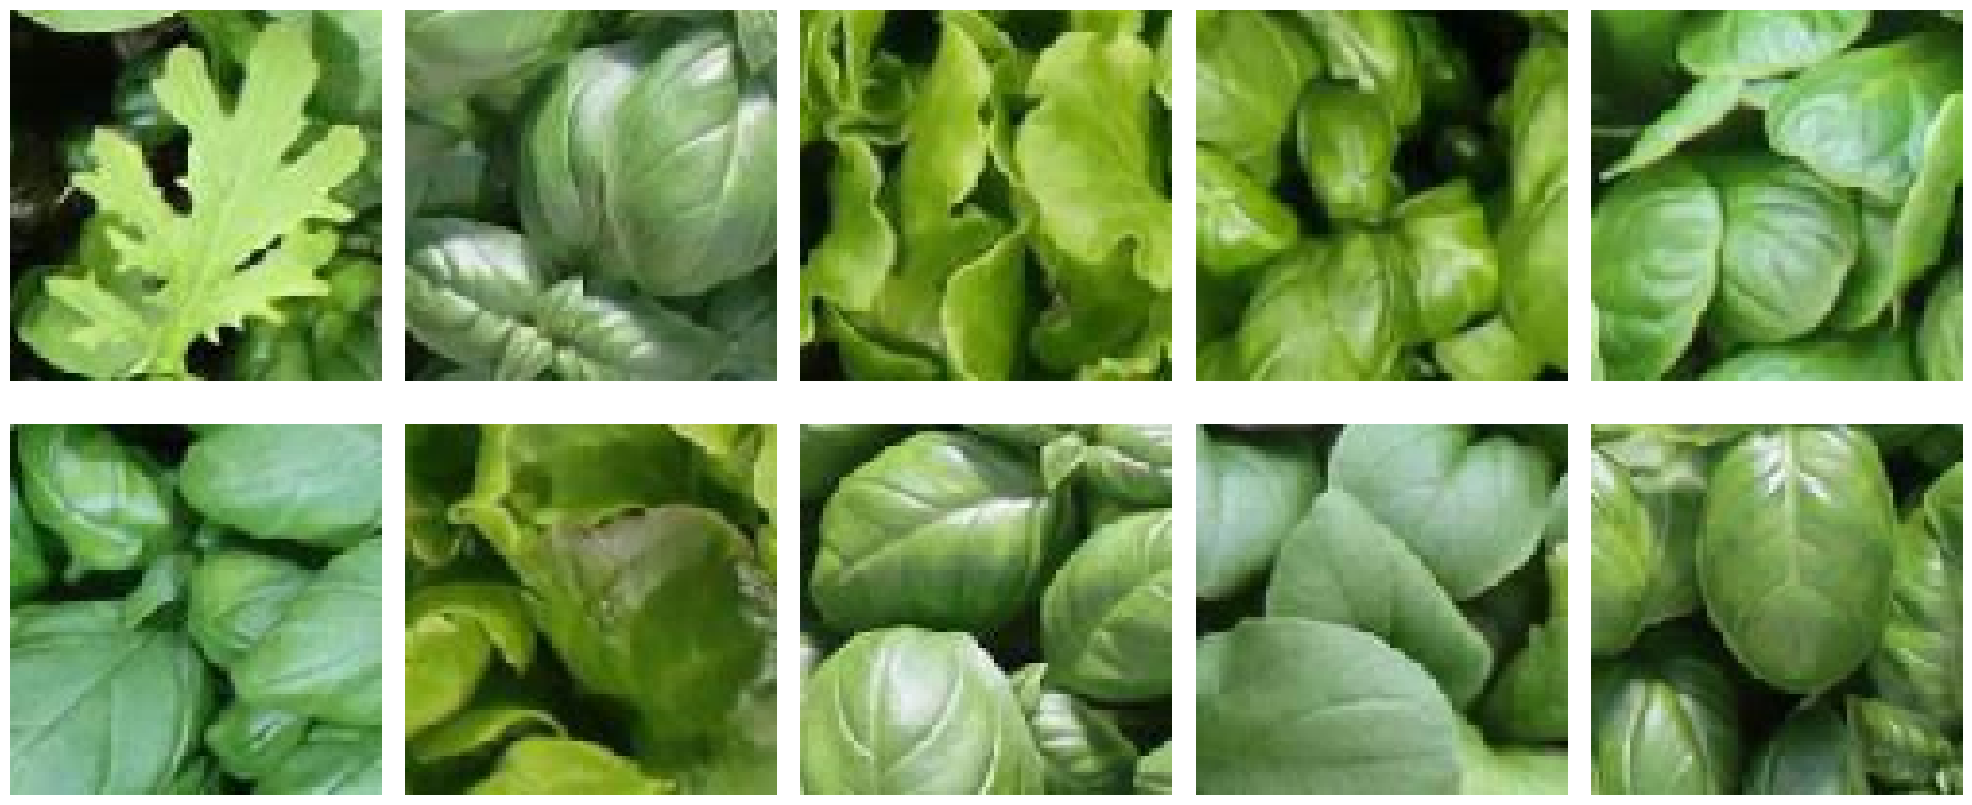

In [14]:
num_img = 10 # Number of images to display
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(x[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
for i in range(num_img):
  print('Sample ', i,' is: ', y[i]) #to see in which class each sample belongs to

Sample  0  is:  ['healthy']
Sample  1  is:  ['healthy']
Sample  2  is:  ['healthy']
Sample  3  is:  ['unhealthy']
Sample  4  is:  ['unhealthy']
Sample  5  is:  ['healthy']
Sample  6  is:  ['unhealthy']
Sample  7  is:  ['healthy']
Sample  8  is:  ['healthy']
Sample  9  is:  ['healthy']


## Remove outliers
by looking at images we found some outliers: images that are not leafs -> remove them

In [16]:
count = 0
images = [0]*5004
for i in range(0,x.shape[0]):
  if not(np.all(x[i] == x[338]) or np.all(x[i] == x[58])):
    images[count] = i # select all the images that are not equal to Shrek or Trololo (red-blue image)
    count +=1
x = x[images]
y = y[images]

## Split train-validation

In [17]:
X_train, X_val, y_train, y_val = train_test_split(x, y, random_state=seed, test_size=.25, stratify=y)

## Training set augmentation

run only one of them, otherwise it will raise error

### 1st augmentation: balance training set

In [18]:
X_train,y_train = augmentation(X_train,y_train)

### 2nd augmentation: increase the number of unhealthy to fine tune models

In [19]:
num_augmented_healthy = 3 # number of augmented healthy images for each image
num_augmented_unhealthy = 4 # number of augmented unhealthy images for each image
datagen = ImageDataGenerator(
    rotation_range=45,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.15,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,  # Randomly zoom inside images
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,
    fill_mode='reflect'  # Strategy used for filling in newly created pixels after rotation or shifting
)


indices = np.where(y_train=="healthy")[0]
X_healthy = X_train[indices]
augmented_healthy = []
for img in X_healthy:
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_healthy.append(batch[0])
        i += 1
        if i >= num_augmented_healthy:
            break
augmented_healthy = np.array(augmented_healthy)
subset_y_healthy = np.ones((len(augmented_healthy), 2)) # (1,0) -> healthy
subset_y_healthy[:, 1] = 0


indices = np.where(y_train=="unhealthy")[0]
X_unhealthy = X_train[indices]
augmented_unhealthy = []
for img in X_unhealthy:
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_unhealthy.append(batch[0])
        i += 1
        if i >= num_augmented_unhealthy:
            break
augmented_unhealthy = np.array(augmented_unhealthy)
subset_y_unhealthy = np.ones((len(augmented_unhealthy), 2)) # (0,1) -> unhealthy
subset_y_unhealthy[:, 0] = 0


X_train_2=np.concatenate((augmented_healthy,augmented_unhealthy),axis=0)
y_train_2=np.concatenate((subset_y_healthy,subset_y_unhealthy),axis=0)

X_train_2, y_train_2= shuffle(X_train, y_train, random_state=0)

## Convert y_val using OneHotEncorder

In [20]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(y_val)
dummy = encoder.transform(y_val).toarray()
Y = pd.DataFrame(dummy,columns=encoder.categories_)
Y = Y.to_numpy()
y_val=Y

#Model

## Transfer learning + MLP

In [21]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

model = tf.keras.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96,96,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)
tfk.utils.plot_model(model, show_shapes=True)
model.trainable = False #we don't want to train the model -> we freeze the pre-trained weights

inputs = tfk.Input(shape=(96, 96, 3))
x = model(inputs)

x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

x = tfkl.Dense(32, activation='relu')(x)
x = tfkl.Dropout(rate=0.3,seed = seed)(x)

outputs = tfkl.Dense(2, activation='softmax')(x)


EfficientNetB3_V2 = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
EfficientNetB3_V2.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])

# Display model summary
EfficientNetB3_V2 .summary()

52606240/52606240 [==============================] - 3s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.724533 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 gap (GlobalAveragePooling2  (None, 1536)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 64)         

In [22]:
EfficientNetB3_V2_history = EfficientNetB3_V2.fit(
    x = preprocess_input(X_train*255), # we apply the preprcessing od Xception architecture
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.9,mode='min', min_lr=1e-7)]
).history

Epoch 1/200
146/146 [==============================] - 32s 66ms/step - loss: 0.6946 - accuracy: 0.5408 - val_loss: 0.6710 - val_accuracy: 0.6443 - lr: 1.0000e-04
Epoch 2/200
146/146 [==============================] - 6s 40ms/step - loss: 0.6623 - accuracy: 0.6178 - val_loss: 0.6113 - val_accuracy: 0.6946 - lr: 1.0000e-04
Epoch 3/200
146/146 [==============================] - 5s 34ms/step - loss: 0.6196 - accuracy: 0.6771 - val_loss: 0.5664 - val_accuracy: 0.7242 - lr: 1.0000e-04
Epoch 4/200
146/146 [==============================] - 5s 34ms/step - loss: 0.5857 - accuracy: 0.7070 - val_loss: 0.5385 - val_accuracy: 0.7498 - lr: 1.0000e-04
Epoch 5/200
146/146 [==============================] - 6s 38ms/step - loss: 0.5527 - accuracy: 0.7332 - val_loss: 0.5053 - val_accuracy: 0.7666 - lr: 1.0000e-04
Epoch 6/200
146/146 [==============================] - 5s 31ms/step - loss: 0.5270 - accuracy: 0.7530 - val_loss: 0.4852 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 7/200
146/146 [============

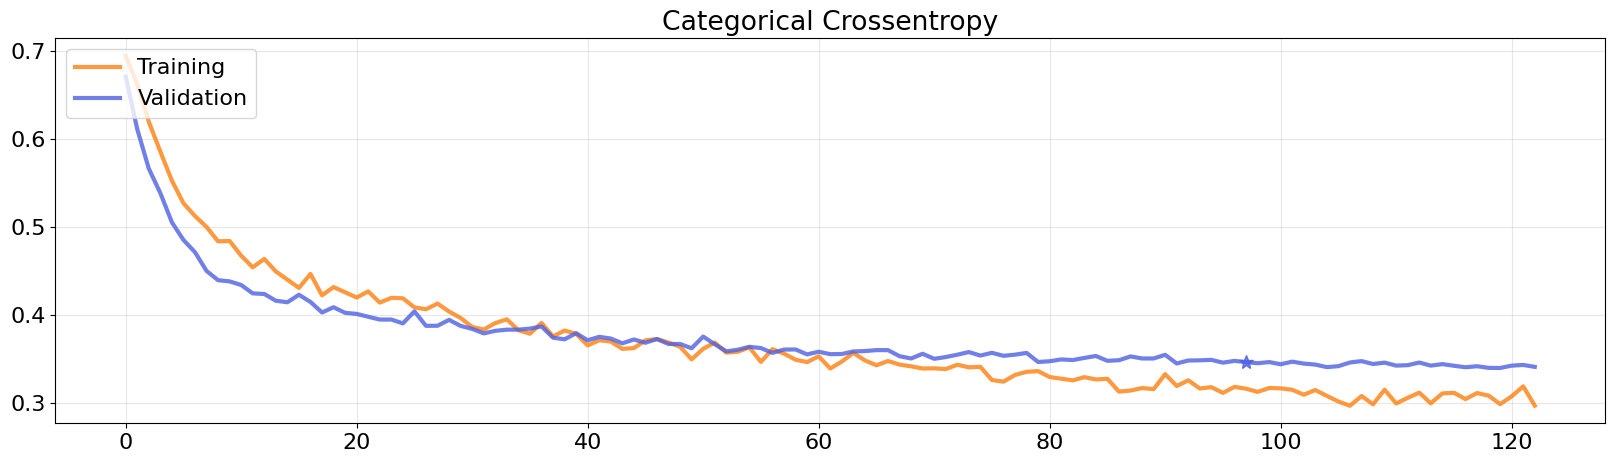

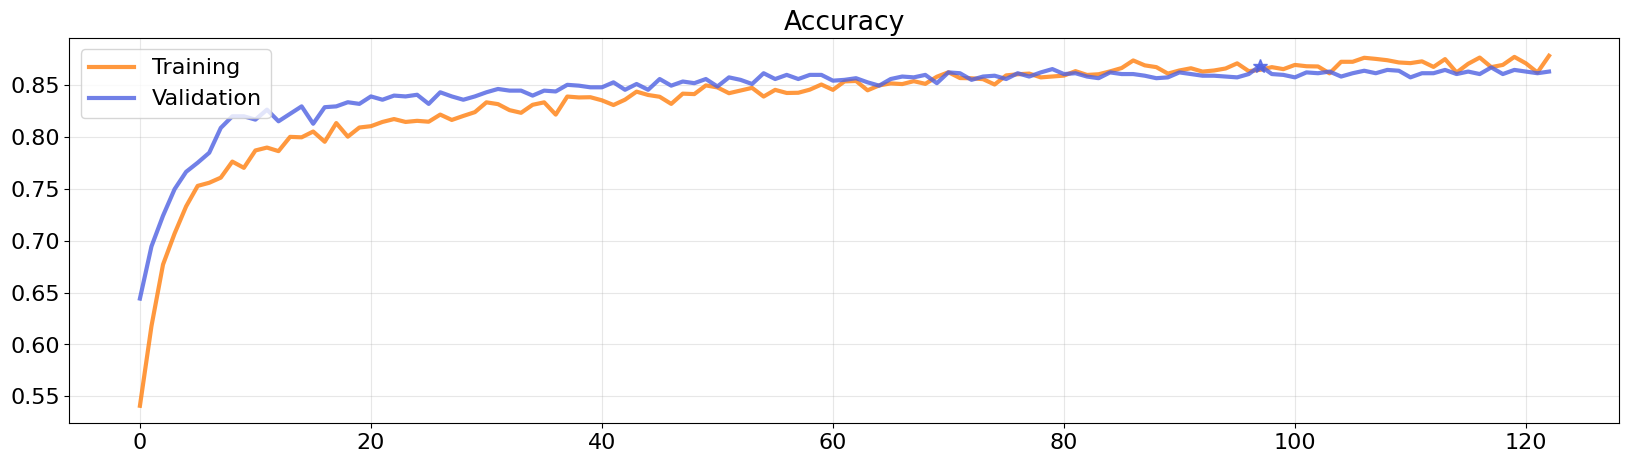

In [23]:
plot_loss_accuracy_trend(EfficientNetB3_V2_history,metrics='val_accuracy')

Accuracy: 0.8689
Precision: 0.8678
Recall: 0.8512
F1: 0.858


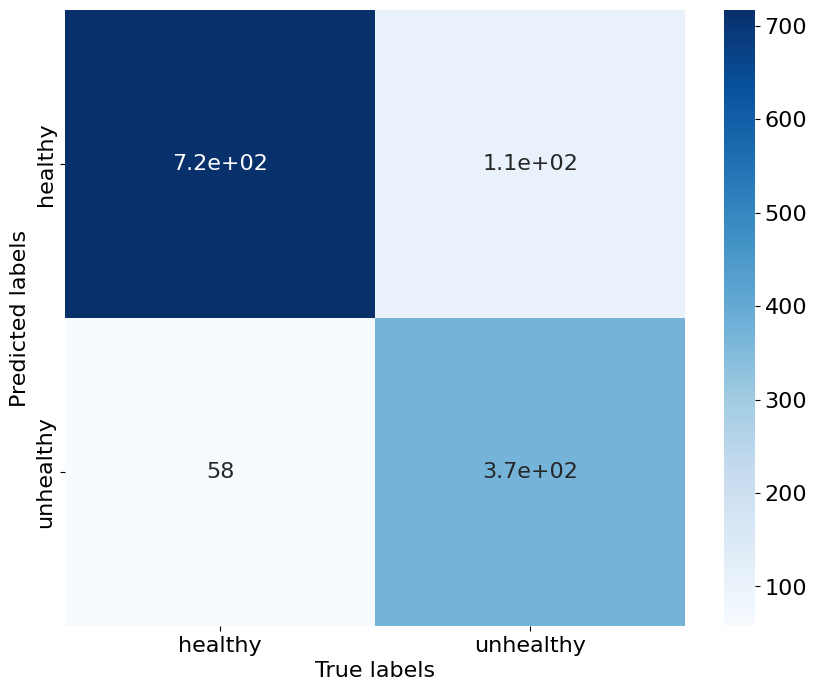

In [24]:
(EfficientNetB3_V2_acc,EfficientNetB3_V2_pre,EfficientNetB3_V2_rec,EfficientNetB3_V2_f1)=show_metrics(EfficientNetB3_V2,X_val,y_val,preprocess_input)

In [25]:
EfficientNetB3_V2.save('EfficientNetB3_V2')

In [26]:
del EfficientNetB3_V2

## Fine tuning on EfficientNetB3V2_MLP using unbalanced data - SELECTED MODEL

In [30]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
EfficientNetB3_V2_ft = tfk.models.load_model('EfficientNetB3_V2')
EfficientNetB3_V2_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 gap (GlobalAveragePooling2  (None, 1536)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

In [31]:
string_model='efficientnetv2-b3'
EfficientNetB3_V2_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block2a_expand_conv True
15 block2a_expand_bn True
16 block2a_expand_activation True
17 block2a_project_conv True
18 block2a_project_bn True
19 block2b_expand_conv True
20 block2b_expand_bn True
21 block2b_expand_activation True
22 block2b_project_conv True
23 block2b_project_bn True
24 block2b_drop True
25 block2b_add True
26 block2c_expand_conv True
27 block2c_expand_bn True
28 block2c_expand_activation True
29 block2c_project_conv True
30 block2c_project_bn True
31 block2c_drop True
32 block2c_add True
33 block3a_expand_conv True
34 block3a_expand_bn True
35 block3a_expand_activation True
36 block3a_project_conv True
37 block3a_project_bn True
38 block3b_expa

In [32]:
N = 406 # we optimize it to reach the right tradeoff between number of learnable parameters and capability to learn
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNetB3_V2_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNetB3_V2_ft.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
37 bl

In [33]:
EfficientNetB3_V2_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(5e-5), metrics='accuracy')

In [34]:
EfficientNetB3_V2_ft_history = EfficientNetB3_V2_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.9, mode='min',min_lr=1e-7)]
).history

Epoch 1/200
291/291 [==============================] - 35s 42ms/step - loss: 0.5445 - accuracy: 0.7966 - val_loss: 0.4254 - val_accuracy: 0.8321 - lr: 5.0000e-05
Epoch 2/200
291/291 [==============================] - 7s 25ms/step - loss: 0.4629 - accuracy: 0.8132 - val_loss: 0.3932 - val_accuracy: 0.8433 - lr: 5.0000e-05
Epoch 3/200
291/291 [==============================] - 10s 33ms/step - loss: 0.4263 - accuracy: 0.8257 - val_loss: 0.3848 - val_accuracy: 0.8433 - lr: 5.0000e-05
Epoch 4/200
291/291 [==============================] - 7s 24ms/step - loss: 0.4196 - accuracy: 0.8229 - val_loss: 0.3740 - val_accuracy: 0.8417 - lr: 5.0000e-05
Epoch 5/200
291/291 [==============================] - 9s 31ms/step - loss: 0.3863 - accuracy: 0.8308 - val_loss: 0.3681 - val_accuracy: 0.8473 - lr: 5.0000e-05
Epoch 6/200
291/291 [==============================] - 7s 24ms/step - loss: 0.3756 - accuracy: 0.8334 - val_loss: 0.3594 - val_accuracy: 0.8441 - lr: 5.0000e-05
Epoch 7/200
291/291 [===========

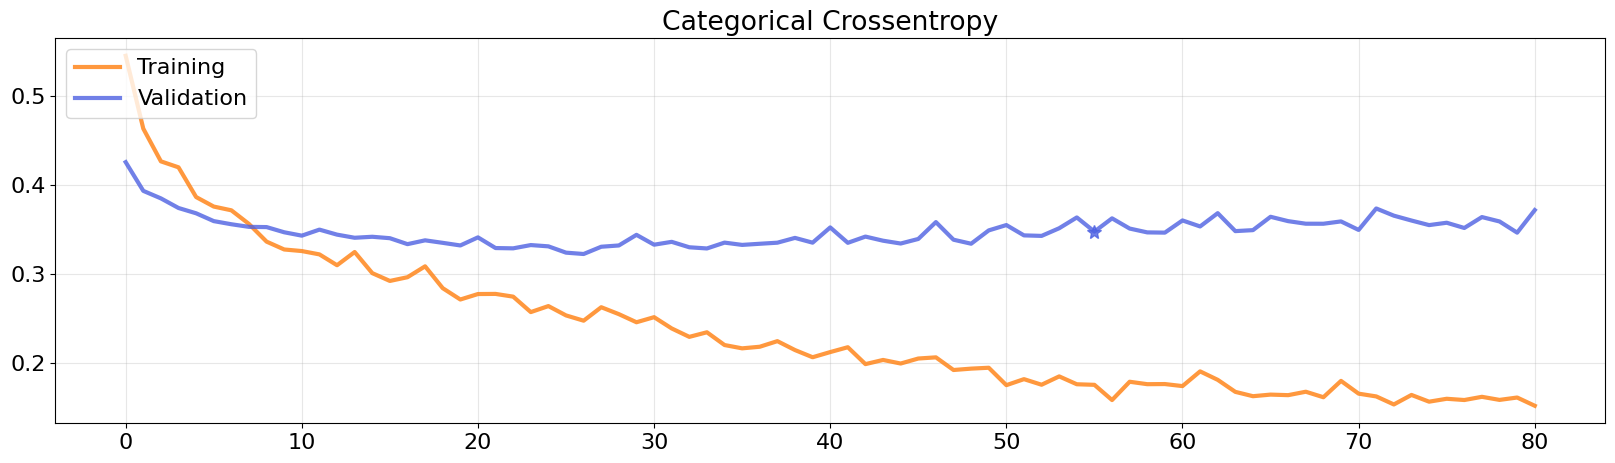

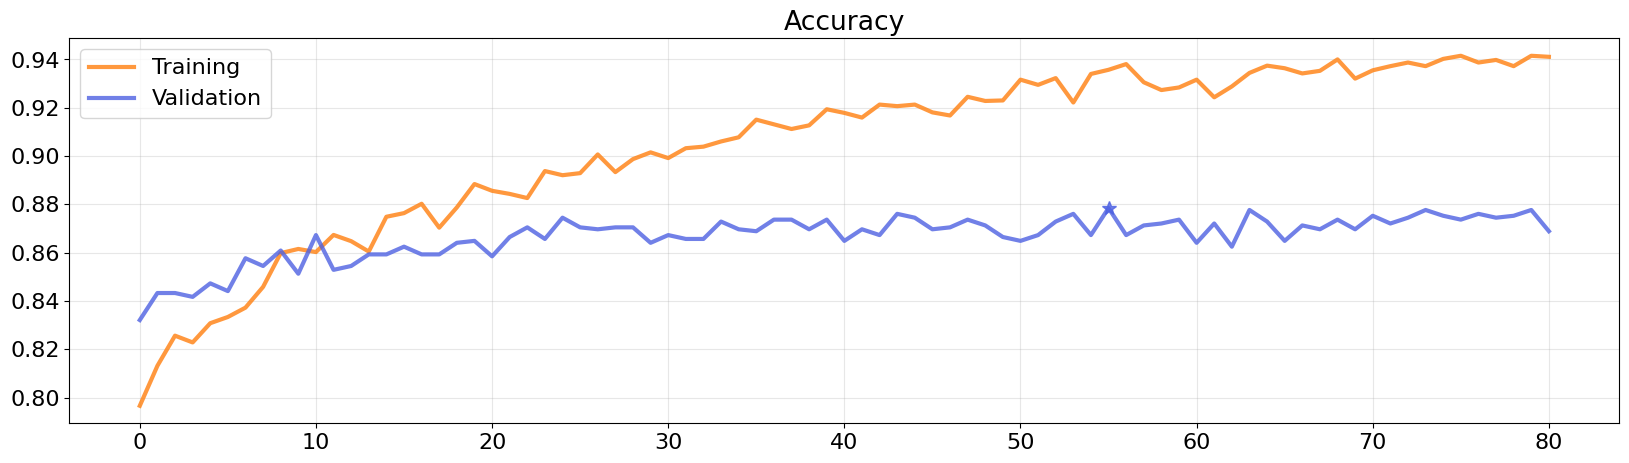

In [35]:
plot_loss_accuracy_trend(EfficientNetB3_V2_ft_history,metrics='val_accuracy')

Accuracy: 0.8785
Precision: 0.8765
Recall: 0.8634
F1: 0.869


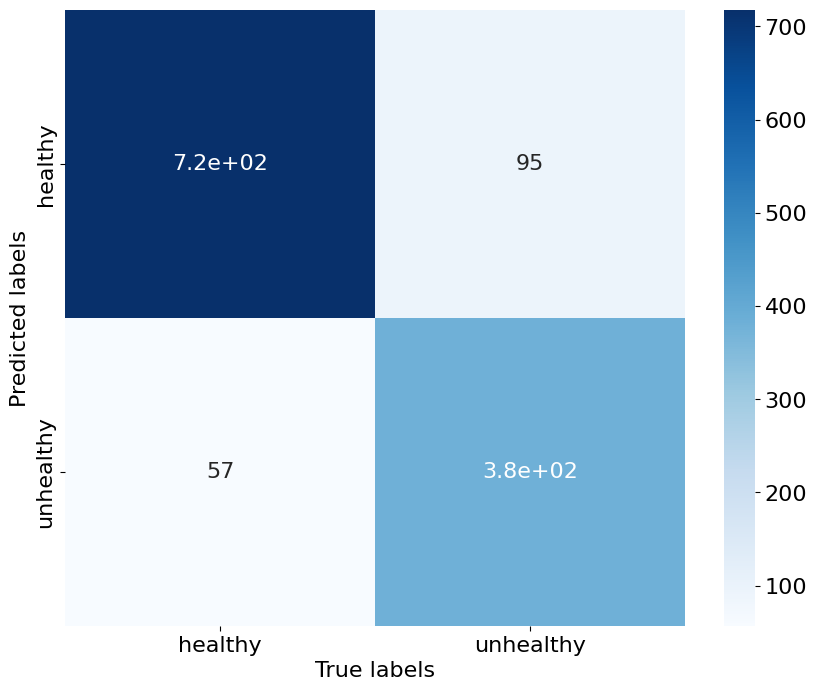

In [36]:
(EfficientNetB3_V2_ft_acc,EfficientNetB3_V2_ft_pre,EfficientNetB3_V2_ft_rec,EfficientNetB3_V2_ft_f1)=show_metrics(EfficientNetB3_V2_ft,X_val,y_val,preprocess_input)

In [37]:
EfficientNetB3_V2_ft.save('Final_model')

In [38]:
del EfficientNetB3_V2_ft

##Fine tuning on EfficientNetV2L_MLP using unbalanced data

In [21]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
EfficientNetV2L_MLP_ft = tfk.models.load_model('EfficientNetV2L_ft')
EfficientNetV2L_MLP_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 117749410 (449.18 MB)
Trainable params: 824322 (3.14 MB)
Non-trainable params: 116925088 (446.03 MB)
_________________________________________________________________


In [22]:
string_model='efficientnetv2-l'
EfficientNetV2L_MLP_ft.get_layer(string_model).trainable = True #we set all the layers of the conv part to trainable
for i, layer in enumerate(EfficientNetV2L_MLP_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 rescaling True
2 stem_conv True
3 stem_bn True
4 stem_activation True
5 block1a_project_conv True
6 block1a_project_bn True
7 block1a_project_activation True
8 block1a_add True
9 block1b_project_conv True
10 block1b_project_bn True
11 block1b_project_activation True
12 block1b_drop True
13 block1b_add True
14 block1c_project_conv True
15 block1c_project_bn True
16 block1c_project_activation True
17 block1c_drop True
18 block1c_add True
19 block1d_project_conv True
20 block1d_project_bn True
21 block1d_project_activation True
22 block1d_drop True
23 block1d_add True
24 block2a_expand_conv True
25 block2a_expand_bn True
26 block2a_expand_activation True
27 block2a_project_conv True
28 block2a_project_bn True
29 block2b_expand_conv True
30 block2b_expand_bn True
31 block2b_expand_activation True
32 block2b_project_conv True
33 block2b_project_bn True
34 block2b_drop True
35 block2b_add True
36 block2c_expand_conv True
37 block2c_expand_bn True
38 block2c_expand_activation

In [23]:
N = 1025
for i, layer in enumerate(EfficientNetV2L_MLP_ft.get_layer(string_model).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(EfficientNetV2L_MLP_ft.get_layer(string_model).layers):
   print(i, layer.name, layer.trainable)
EfficientNetV2L_MLP_ft.summary()

0 input_3 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expand

In [24]:
EfficientNetV2L_MLP_ft.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [25]:
EfficientNetV2L_MLP_ft_history = EfficientNetV2L_MLP_ft.fit(
    x = preprocess_input(X_train_2*255),
    y = y_train_2,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=13, restore_best_weights=True)]
).history

Epoch 1/200
291/291 [==============================] - 77s 132ms/step - loss: 0.2358 - accuracy: 0.9026 - val_loss: 0.2943 - val_accuracy: 0.8785
Epoch 2/200
291/291 [==============================] - 24s 83ms/step - loss: 0.2353 - accuracy: 0.9084 - val_loss: 0.2939 - val_accuracy: 0.8809
Epoch 3/200
291/291 [==============================] - 23s 81ms/step - loss: 0.2345 - accuracy: 0.9054 - val_loss: 0.2965 - val_accuracy: 0.8745
Epoch 4/200
291/291 [==============================] - 35s 119ms/step - loss: 0.2290 - accuracy: 0.9151 - val_loss: 0.2970 - val_accuracy: 0.8745
Epoch 5/200
291/291 [==============================] - 23s 79ms/step - loss: 0.2359 - accuracy: 0.9063 - val_loss: 0.2974 - val_accuracy: 0.8769
Epoch 6/200
291/291 [==============================] - 24s 82ms/step - loss: 0.2309 - accuracy: 0.9076 - val_loss: 0.2981 - val_accuracy: 0.8777
Epoch 7/200
291/291 [==============================] - 23s 79ms/step - loss: 0.2275 - accuracy: 0.9119 - val_loss: 0.2977 - val_

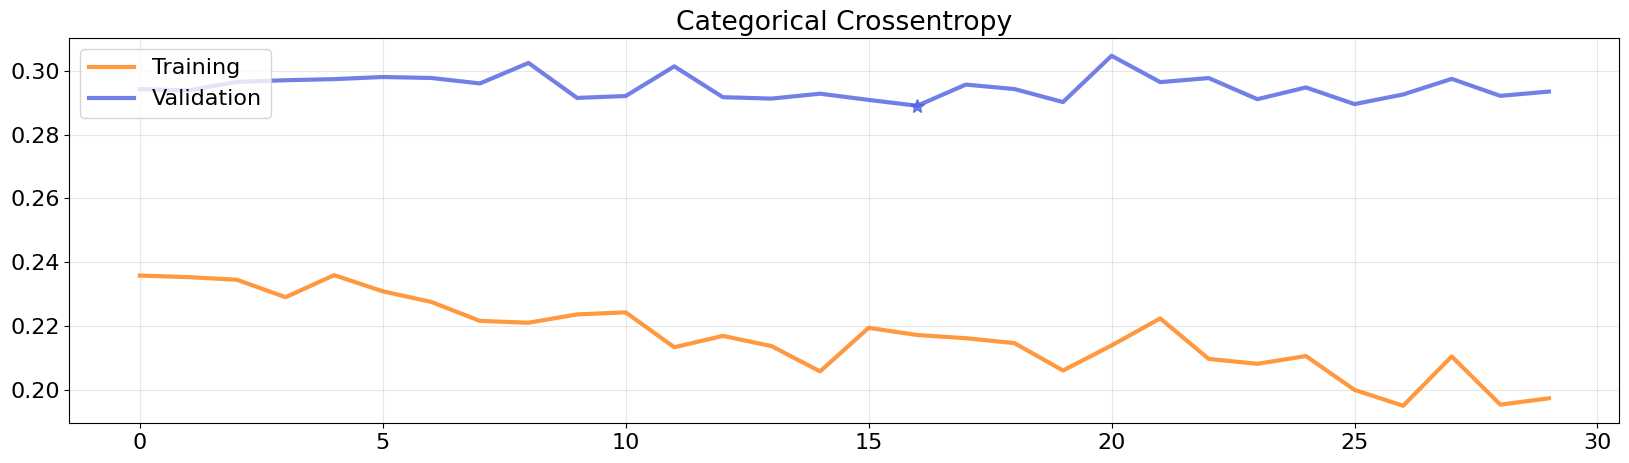

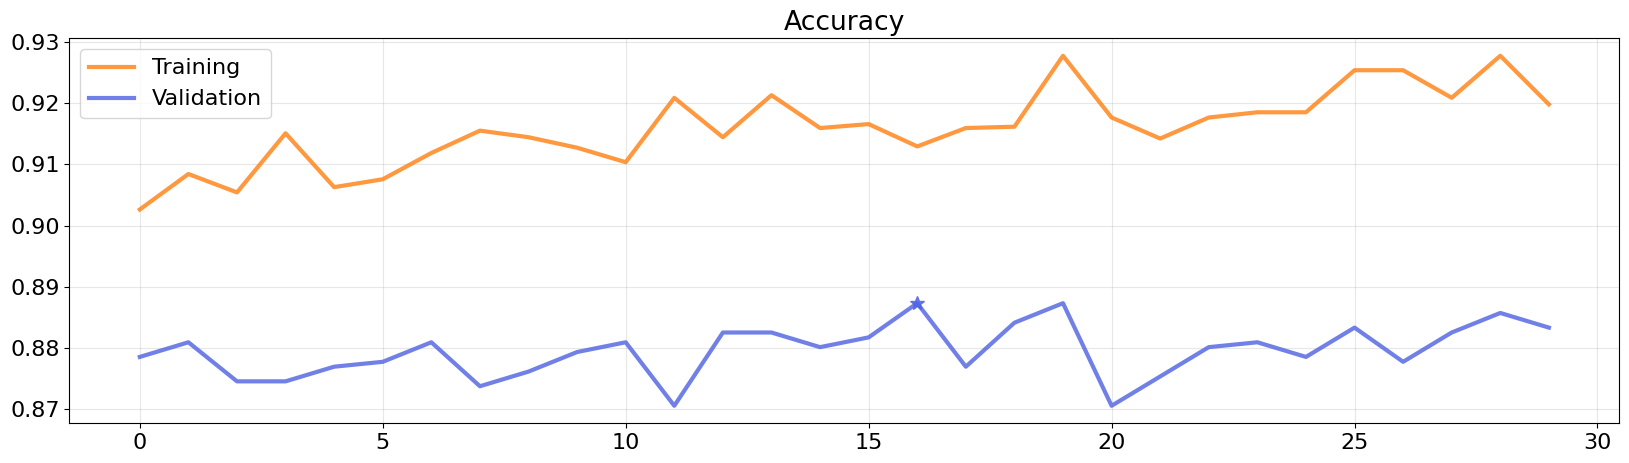

In [26]:
plot_loss_accuracy_trend(EfficientNetV2L_MLP_ft_history,metrics='val_accuracy')

Accuracy: 0.8873
Precision: 0.8832
Recall: 0.8762
F1: 0.8794


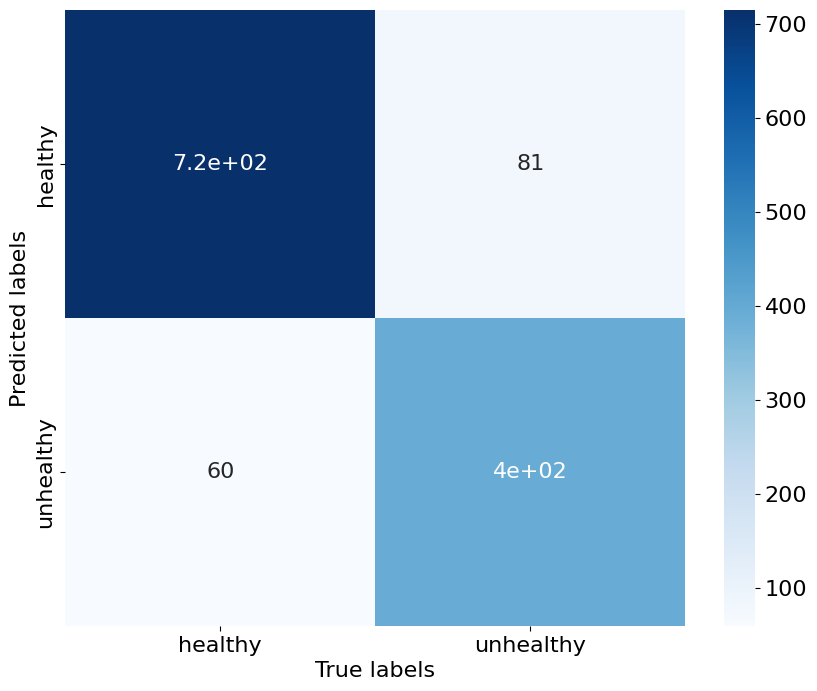

In [27]:
(EfficientNetV2L_MLP_ft_acc,EfficientNetV2L_MLP_ft_pre,EfficientNetV2L_MLP_ft_rec,EfficientNetV2L_MLP_ft_f1)=show_metrics(EfficientNetV2L_MLP_ft,X_val,y_val,preprocess_input)

In [28]:
EfficientNetV2L_MLP_ft.save('EfficientNetV2L_MLP_ft')

In [29]:
del EfficientNetV2L_MLP_ft